## **Getting the dataset**

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'xxxxx'
os.environ['KAGGLE_KEY'] = 'xxxxx'

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

## **Checking out the data/images**

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

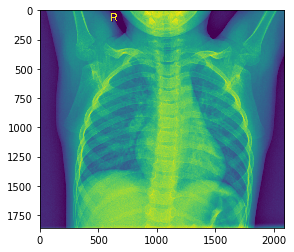

In [6]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

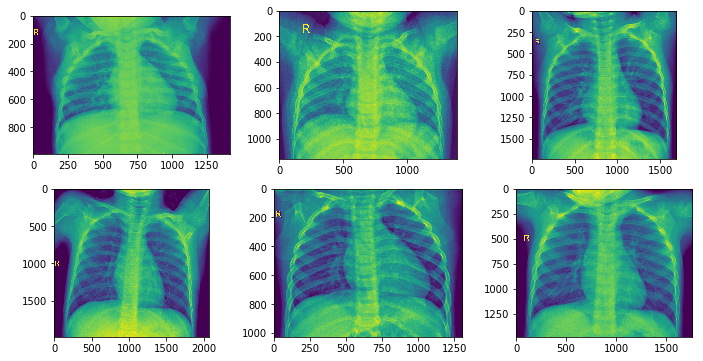

In [8]:
plot_images(training_dir + '/NORMAL')

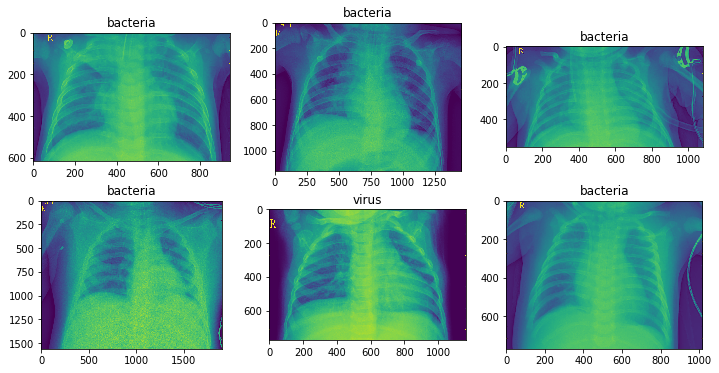

In [9]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

## **Train the model**

In [10]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [11]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [13]:
model = get_model()









87916544/87910968 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________

In [14]:

model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 318s 2s/step - loss: 0.4012 - acc: 0.8577 - val_loss: 4.0114 - val_acc: 0.6298
Epoch 2/5
163/163 [==============================] - 313s 2s/step - loss: 0.2671 - acc: 0.8982 - val_loss: 5.2604 - val_acc: 0.6266
Epoch 3/5
163/163 [==============================] - 313s 2s/step - loss: 0.2732 - acc: 0.8921 - val_loss: 4.5141 - val_acc: 0.4263
Epoch 4/5
163/163 [==============================] - 318s 2s/step - loss: 0.2438 - acc: 0.8984 - val_loss: 0.8715 - val_acc: 0.7612
Epoch 5/5
163/163 [==============================] - 317s 2s/step - loss: 0.2520 - acc: 0.8978 - val_loss: 1.6726 - val_acc: 0.6939


## **Evaluate the model**

In [19]:
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 83ms/step
Loss: 2.4773170406354694
Accuracy: 0.5625


In [35]:
y_pred_batches = []
y_true_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

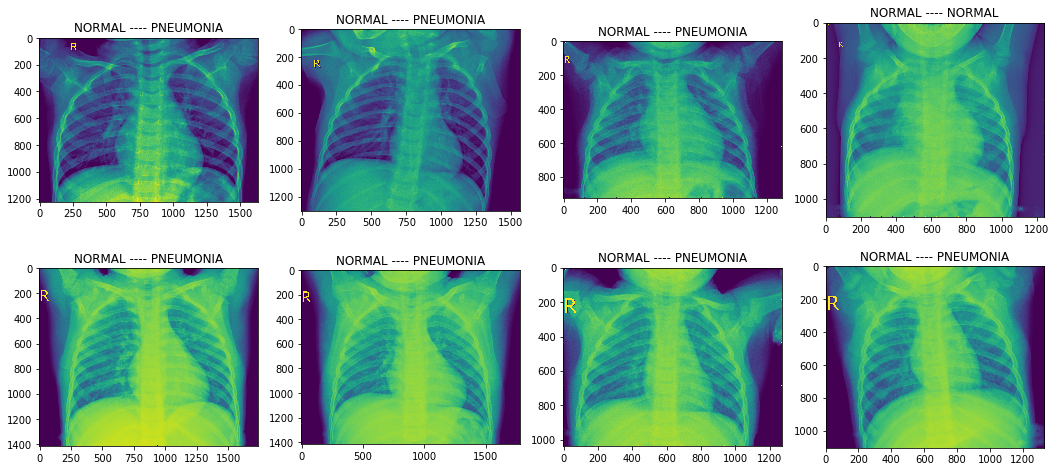

In [37]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

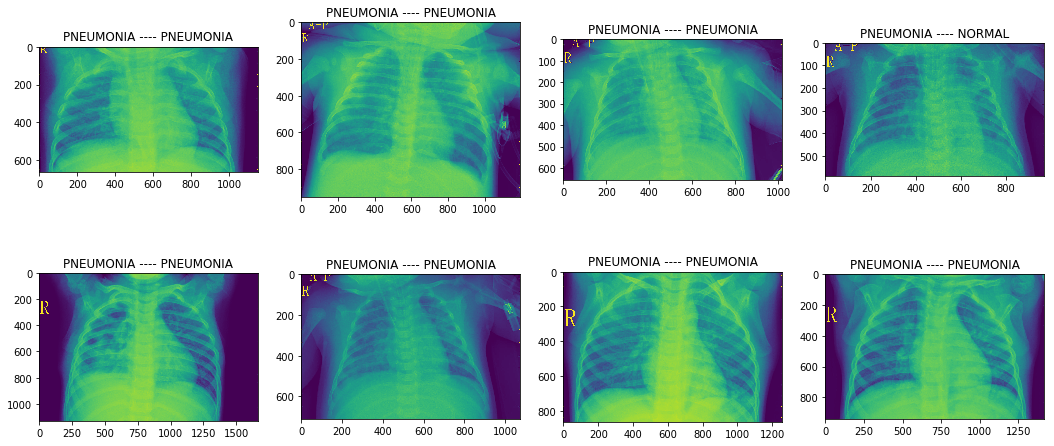

In [38]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

## **Model saving and loading**

In [0]:
model.save('Bilal_model.h5')

In [0]:
new_model = keras.models.load_model('Bilal_model.h5')